In [1]:
from pathlib import Path
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pandas as pd
import numpy as np
import wandb
import torch
from torch import nn
import sys
sys.path.append(str(Path.cwd().parent))
from viz_utils import load_dfiv_model, predict_dfiv_model, load_dfiv_runs
import plotly.express as px
from src.data.demand_design_parcs_revise import psi, f

In [2]:

from IPython.display import display, HTML
import plotly
plotly.offline.init_notebook_mode(connected=True)

# The polling here is to ensure that plotly.js has already been loaded before
# setting display alignment in order to avoid a race condition.
display(HTML(
    '<script>'
        'var waitForPlotly = setInterval( function() {'
            'if( typeof(window.Plotly) !== "undefined" ){'
                'MathJax.Hub.Config({ SVG: { font: "STIX-Web" }, displayAlign: "center" });'
                'MathJax.Hub.Queue(["setRenderer", MathJax.Hub, "SVG"]);'
                'clearInterval(waitForPlotly);'
            '}}, 250 );'
    '</script>'
))

In [3]:
entity, project = "jasmineqy0", "formal_4"  

# Heteroscedasticity Visualization

In [4]:
# from src.data.demand_design import psi, f
from src.data.demand_design_parcs_revise import psi, f

In [5]:
num_point = 50000

In [6]:
rng = np.random.default_rng(seed=0)

emotion = rng.choice(list(range(1, 8)), num_point)
time = rng.uniform(0, 10, num_point)
cost = rng.normal(0, 1.0, num_point)
rho = 0.5

noise_price = rng.normal(0, 1, num_point)
price = 25 + (cost + 3) * psi(time) + noise_price

In [7]:
phi = [0.1, 0.3, 0.5, 0.7, 0.9]
scaled_noise_price = 1 / (1 + np.exp(-noise_price))
hetero_noise_demand = [rng.normal(rho*noise_price, (1-scale**2)*scaled_noise_price, size=num_point) for scale in phi]
normal_noise_demand = [rng.normal(rho*noise_price, 1-scale**2, size=num_point) for scale in phi]

In [8]:
# normal_demand = f(price, time, emotion) + normal_noise_demand
# hetero_demand = [f(price, time, emotion) + noise for noise in hetero_noise_demand]

In [9]:
plt.rcParams.update({
    'font.size': 15
})

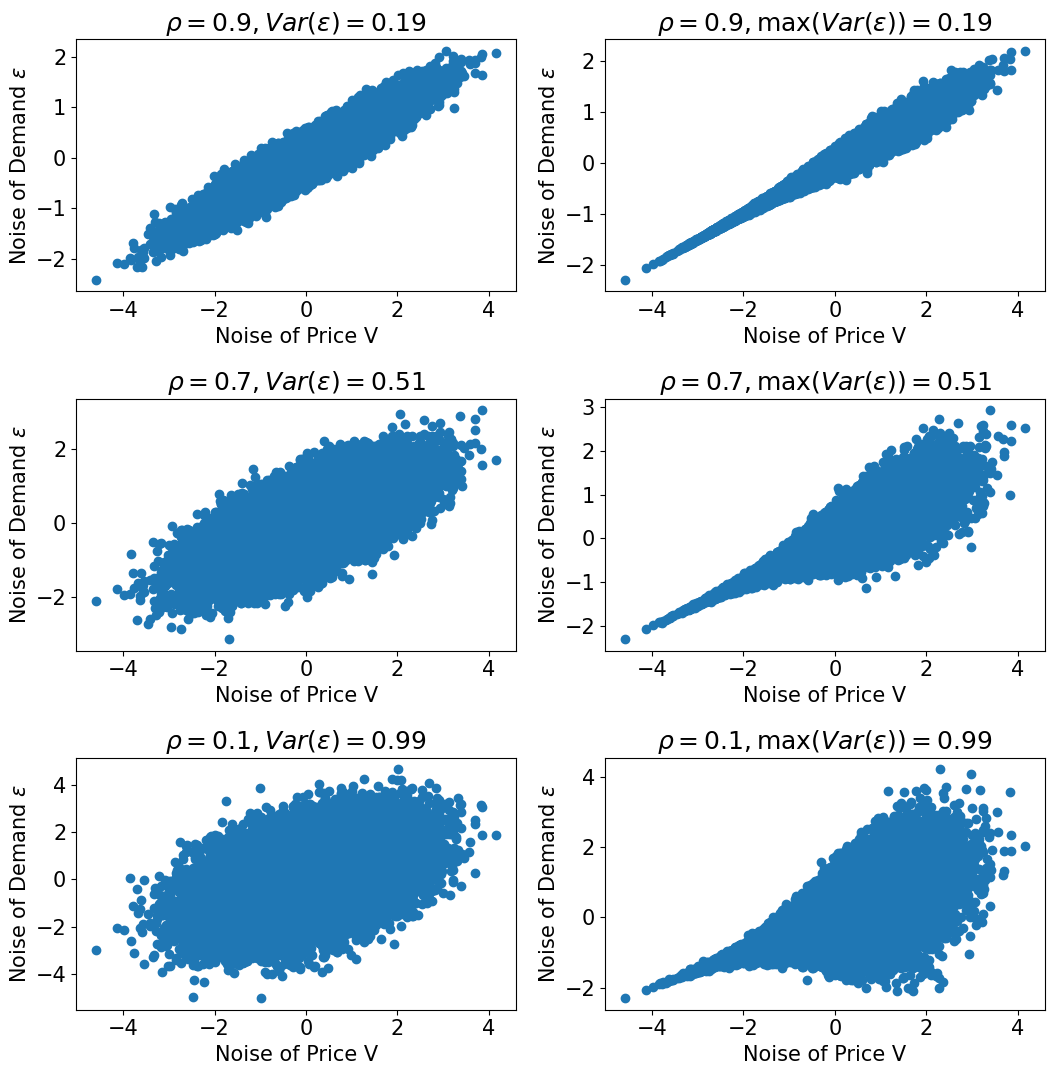

In [10]:
fig, axs = plt.subplots(3, 2, figsize=(11, 11))

axs[0, 0].scatter(noise_price, normal_noise_demand[-1])
axs[0, 0].set_title(r'$\rho=0.9, Var(\epsilon) = 0.19$')
axs[0, 0].set_xlabel('Noise of Price V')
axs[0, 0].set_ylabel('Noise of Demand $\epsilon$')

axs[0, 1].scatter(noise_price, hetero_noise_demand[-1])
axs[0, 1].set_title(r'$\rho=0.9, \max(Var(\epsilon)) = 0.19$')
axs[0, 1].set_xlabel('Noise of Price V')
axs[0, 1].set_ylabel('Noise of Demand $\epsilon$')

axs[1, 0].scatter(noise_price, normal_noise_demand[3])
axs[1, 0].set_title(r'$\rho=0.7, Var(\epsilon) = 0.51$')
axs[1, 0].set_xlabel('Noise of Price V')
axs[1, 0].set_ylabel('Noise of Demand $\epsilon$')

axs[1, 1].scatter(noise_price, hetero_noise_demand[3])
axs[1, 1].set_title(r'$\rho=0.7, \max(Var(\epsilon)) = 0.51$')
axs[1, 1].set_xlabel('Noise of Price V')
axs[1, 1].set_ylabel('Noise of Demand $\epsilon$')

axs[2, 0].scatter(noise_price, normal_noise_demand[0])
axs[2, 0].set_title(r'$\rho=0.1, Var(\epsilon) = 0.99$')
axs[2, 0].set_xlabel('Noise of Price V')
axs[2, 0].set_ylabel('Noise of Demand $\epsilon$')

axs[2, 1].scatter(noise_price, hetero_noise_demand[0])
axs[2, 1].set_title(r'$\rho=0.1, \max(Var(\epsilon))= 0.99$')
axs[2, 1].set_xlabel('Noise of Price V')
axs[2, 1].set_ylabel('Noise of Demand $\epsilon$')

plt.tight_layout()
fig.savefig(f'images/hetero_noise.png')

# Original

In [64]:
group = 'dfiv_low_dim_parcs'
runs_df = load_dfiv_runs(entity, project, filters={'group' : group})

In [65]:
runs_df = runs_df[runs_df['state'].apply(lambda x: x == 'finished')]
runs_df = runs_df[runs_df['summary'].apply(lambda x: x['min_test_loss'] is not None)]
# runs_df = runs_df[runs_df['config'].apply(lambda x: x['data_configs']['data_size'] == 10000)]
print('Number of runs: ', len(runs_df))

Number of runs:  600


In [66]:
grouped_df = runs_df.groupby(runs_df['config'].apply(lambda x: x['data_configs']['rho']))

for group, group_df in grouped_df:
    print("Group:", group)
    
    test_loss_idx = group_df['summary'].apply(lambda x: True if 'min_test_loss' in x else False)
    test_loss_df = group_df[test_loss_idx]
    print('\t Number of runs with test loss: ', len(test_loss_df))

    original_test_loss = test_loss_df['summary'].apply(lambda x: x['min_test_loss'])

    min_idx, min_test_loss = np.argmin(original_test_loss), np.min(original_test_loss)
    print(f"\t min test loss: {min_test_loss}")

    original_mean_test_loss = np.mean(original_test_loss)
    print('\t mean test loss: ', original_mean_test_loss)

    original_std_test_loss = np.std(original_test_loss)
    print('\t std test loss: ', original_std_test_loss)

    original_median_test_loss = np.median(original_test_loss)
    print('\tmedian test loss: ', original_median_test_loss)

Group: 0.1
	 Number of runs with test loss:  100
	 min test loss: 81.57099151611328
	 mean test loss:  142.0247208404541
	 std test loss:  25.709039958034364
	median test loss:  144.13056182861328
Group: 0.3
	 Number of runs with test loss:  100
	 min test loss: 69.18988037109375
	 mean test loss:  144.3465030670166
	 std test loss:  28.941161166919965
	median test loss:  139.97457885742188
Group: 0.5
	 Number of runs with test loss:  100
	 min test loss: 64.79553985595703
	 mean test loss:  140.11448707580567
	 std test loss:  28.97407069246733
	median test loss:  138.12246704101562
Group: 0.7
	 Number of runs with test loss:  100
	 min test loss: 85.2149658203125
	 mean test loss:  142.94844192504883
	 std test loss:  26.36454816530712
	median test loss:  141.00408935546875
Group: 0.9
	 Number of runs with test loss:  100
	 min test loss: 72.32183837890625
	 mean test loss:  135.02911567687988
	 std test loss:  26.599725069009462
	median test loss:  134.5443115234375
Group: 1.0
	 Num

In [67]:
# test_loss_idx = runs_df['summary'].apply(lambda x: True if 'min_test_loss' in x else False)
# test_loss_df = runs_df[test_loss_idx]
# print('Number of runs with test loss: ', len(test_loss_df))

# original_test_loss = test_loss_df['summary'].apply(lambda x: x['min_test_loss'])

# min_idx, min_test_loss = np.argmin(original_test_loss), np.min(original_test_loss)
# print(f"min test loss: {min_test_loss}\n")

# original_mean_test_loss = np.mean(original_test_loss)
# print('mean test loss: ', original_mean_test_loss)

# original_std_test_loss = np.std(original_test_loss)
# print('std test loss: ', original_std_test_loss)

# original_median_test_loss = np.median(original_test_loss)
# print('mean test loss: ', original_median_test_loss)

In [68]:
# best_run = runs_df_tmp.iloc[min_idx]
# assert best_run['summary']['min_test_loss'] == min_test_loss, 'min test loss not equal to min test loss in test loss df'
# best_run_name, best_run_id = best_run['name'], best_run['id']
# print(f'best run name: {best_run_name}, best run id: {best_run_id}')

# run_path_original = '/'.join([entity, project, best_run_id])
# print(f'best run path: {run_path_original}')

# dfiv_original_model = load_dfiv_model(run_path_original)

In [69]:
# original_test_rho = test_loss_df['config'].apply(lambda x: x['data_configs']['rho'])
# # original_test_sigma = test_loss_df['config'].apply(lambda x: x['data_configs']['sigma'])
# original_test_sigma = len(original_test_rho) * [0]

# original_sigma_seq = np.unique(np.sort(original_test_sigma)).tolist()

# df_original = pd.DataFrame({'sigma': original_test_sigma, 'rho': original_test_rho, 'test loss': original_test_loss})
# df_original = df_original.groupby(['sigma', 'rho']).mean().reset_index()

# Stage 1

In [ ]:
group = 'dfiv_low_dim_hetero_stage_1'
runs_df = load_dfiv_runs(entity, project, filters={'group' : group})
runs_df = runs_df[runs_df['state'].apply(lambda x: x == 'finished')]
runs_df = runs_df[runs_df['config'].apply(lambda x: x['data_configs']['data_size'] == 10000)]

In [ ]:
test_loss_idx = runs_df['summary'].apply(lambda x: True if 'test loss' in x else False)
test_loss_df = runs_df[test_loss_idx]

stage_1_test_loss = test_loss_df['summary'].apply(lambda x: x['test loss'])

min_idx, min_test_loss = np.argmin(stage_1_test_loss), np.min(stage_1_test_loss)
print(f"min test loss: {best_run['summary']['test loss']}\n")

stage_1_mean_test_loss = np.mean(stage_1_test_loss)
print('mean test loss: ', stage_1_mean_test_loss)

stage_1_std_test_loss = np.std(stage_1_test_loss)
print('std test loss: ', stage_1_std_test_loss)

min test loss: 777.747314453125

mean test loss:  65590.43138999939
std test loss:  119966.78165491723


In [16]:
best_run = runs_df.iloc[min_idx]
assert best_run['summary']['test loss'] == min_test_loss, 'min test loss not equal to min test loss in test loss df'
best_run_name, best_run_id = best_run['name'], best_run['id']
print(f'best run name: {best_run_name}, best run id: {best_run_id}')

run_path_stage_1 = '/'.join([entity, project, best_run_id])
print(f'best run path: {run_path_stage_1}')

dfiv_hetero_stage_1_model = load_dfiv_model(run_path_stage_1)

best run name: pretty-sea-82, best run id: uvd37emt
best run path: jasmineqy0/formal_1/uvd37emt


In [17]:
stage_1_test_sigma = test_loss_df['config'].apply(lambda x: x['data_configs']['sigma'])
stage_1_test_rho = test_loss_df['config'].apply(lambda x: x['data_configs']['rho'])

stage_1_sigma_seq = np.unique(np.sort(stage_1_test_sigma)).tolist()

df_stage_1 = pd.DataFrame({'sigma': stage_1_test_sigma, 'rho': stage_1_test_rho, 'test loss': stage_1_test_loss})
df_mean_stage_1 = df_stage_1.groupby(['sigma', 'rho']).mean().reset_index()
df_mean_stage_1

,sigma,rho,test loss
0,0.0,0.5,58818.069125
1,0.2,0.5,51568.617723
2,1.0,0.5,59838.294971
3,1.8,0.5,92136.743741


In [18]:
fig = px.box(df_stage_1, x='sigma', y='test loss', title='Stage 1 Test Loss',
             category_orders={'sigma':np.unique(np.sort(stage_1_test_sigma)).tolist(),})
fig.update_xaxes(type='category')
fig.show()

In [19]:
fig = px.bar(df_mean_stage_1, x='sigma', y='test loss', title='Stage 1 Mean Test Loss',
             category_orders={'sigma':np.unique(np.sort(stage_1_test_sigma)).tolist(),})
fig.update_xaxes(type='category')
fig.show()

# Stage 2

In [70]:
group = 'dfiv_low_dim_hetero_stage_2_1'
runs_df = load_dfiv_runs(entity, project, filters={'group' : group})
print('Number of runs: ', len(runs_df))

Number of runs:  600


In [71]:
runs_df = runs_df[runs_df['state'].apply(lambda x: x == 'finished')]
runs_df = runs_df[runs_df['summary'].apply(lambda x: x['min_test_loss'] is not None)]
# runs_df = runs_df[runs_df['config'].apply(lambda x: x['data_configs']['data_size'] == 10000)]
print('Number of runs: ', len(runs_df))

Number of runs:  600


In [72]:
grouped_df = runs_df.groupby(runs_df['config'].apply(lambda x: x['data_configs']['rho']))

for group, group_df in grouped_df:
    print("Group:", group)
    
    test_loss_idx = group_df['summary'].apply(lambda x: True if 'min_test_loss' in x else False)
    test_loss_df = group_df[test_loss_idx]
    print('\tNumber of runs with test loss: ', len(test_loss_df))

    original_test_loss = test_loss_df['summary'].apply(lambda x: x['min_test_loss'])

    min_idx, min_test_loss = np.argmin(original_test_loss), np.min(original_test_loss)
    print(f"\tmin test loss: {min_test_loss}")

    original_mean_test_loss = np.mean(original_test_loss)
    print('\tmean test loss: ', original_mean_test_loss)

    original_std_test_loss = np.std(original_test_loss)
    print('\tstd test loss: ', original_std_test_loss)

    original_median_test_loss = np.median(original_test_loss)
    print('\tmedian test loss: ', original_median_test_loss)

Group: 0.1
	Number of runs with test loss:  100
	min test loss: 20050.853515625
	mean test loss:  131026.5678125
	std test loss:  67715.92402410338
	median test loss:  137163.046875
Group: 0.3
	Number of runs with test loss:  100
	min test loss: 19215.23828125
	mean test loss:  127418.94845703125
	std test loss:  69334.79285889154
	median test loss:  136017.3984375
Group: 0.5
	Number of runs with test loss:  100
	min test loss: 18651.228515625
	mean test loss:  137273.36455078126
	std test loss:  65904.04516489297
	median test loss:  150206.296875
Group: 0.7
	Number of runs with test loss:  100
	min test loss: 18479.12890625
	mean test loss:  117877.2595703125
	std test loss:  71490.30008937136
	median test loss:  115606.4609375
Group: 0.9
	Number of runs with test loss:  100
	min test loss: 17227.015625
	mean test loss:  116110.9965625
	std test loss:  67179.52378857993
	median test loss:  121443.01171875
Group: 1.0
	Number of runs with test loss:  100
	min test loss: 17667.326171875


In [63]:
# test_loss_idx = runs_df['summary'].apply(lambda x: True if 'test loss' in x else False)
# test_loss_df = runs_df[test_loss_idx]

# stage_2_test_loss = test_loss_df['summary'].apply(lambda x: x['min_test_loss'])

# min_idx, min_test_loss = np.argmin(stage_2_test_loss), np.min(stage_2_test_loss)
# print(f"min test loss: {best_run['summary']['min_test_loss']}\n")

# stage_2_mean_test_loss = np.mean(stage_2_test_loss)
# print('mean test loss: ', stage_2_mean_test_loss)

# stage_2_std_test_loss = np.std(stage_2_test_loss)
# print('std test loss: ', stage_2_std_test_loss)

In [62]:
# best_run = runs_df.iloc[min_idx]
# assert best_run['summary']['min_test_loss'] == min_test_loss, 'min test loss not equal to min test loss in test loss df'
# best_run_name, best_run_id = best_run['name'], best_run['id']
# print(f'best run name: {best_run_name}, best run id: {best_run_id}')

# run_path_stage_2 = '/'.join([entity, project, best_run_id])
# print(f'best run path: {run_path_stage_2}')

# dfiv_hetero_stage_2_model = load_dfiv_model(run_path_stage_2)

In [23]:
# stage_2_test_sigma = test_loss_df['config'].apply(lambda x: x['data_configs']['sigma'])
# stage_2_test_rho = test_loss_df['config'].apply(lambda x: x['data_configs']['rho'])

# stage_2_sigma_seq = np.unique(np.sort(stage_2_test_sigma)).tolist()

# df_stage_2 = pd.DataFrame({'sigma': stage_2_test_sigma, 'rho': stage_2_test_rho, 'test loss': stage_2_test_loss})
# df_mean_stage_2 = df_stage_2.groupby(['sigma', 'rho']).mean().reset_index()

In [61]:
# fig = px.box(df_stage_2, x='sigma', y='test loss', title='Stage 2 Test Loss',
#              category_orders={'sigma':np.unique(np.sort(stage_1_test_sigma)).tolist(),})
# fig.update_xaxes(type='category')
# fig.show()

In [60]:
# fig = px.bar(df_mean_stage_2, x='sigma', y='test loss', 
#              facet_col='rho', 
#              title='Stage 2 Mean Test Loss',
#              category_orders={'sigma':np.unique(np.sort(stage_2_test_sigma)).tolist(),})
# fig.update_xaxes(type='category')
# fig.show()

# CATE

In [26]:
num_point = 50

In [27]:
# vary t: fix p = 25, S = E[S]
emotion_range = np.array([1, 2, 3, 4, 5, 6, 7])
price_val = 25
price = np.ones(num_point) * price_val
time = np.linspace(0.0, 10, num_point)
emotion = (np.ones(num_point) * np.mean(emotion_range))
covariate = np.c_[time, emotion]

In [28]:
true_demand = f(price, time, emotion)

price = price[:, np.newaxis]
original_demand = predict_dfiv_model(dfiv_original_model, price, covariate)
stage_1_pred_demand = predict_dfiv_model(dfiv_hetero_stage_1_model, price, covariate)
stage_2_pred_demand = predict_dfiv_model(dfiv_hetero_stage_2_model, price, covariate)


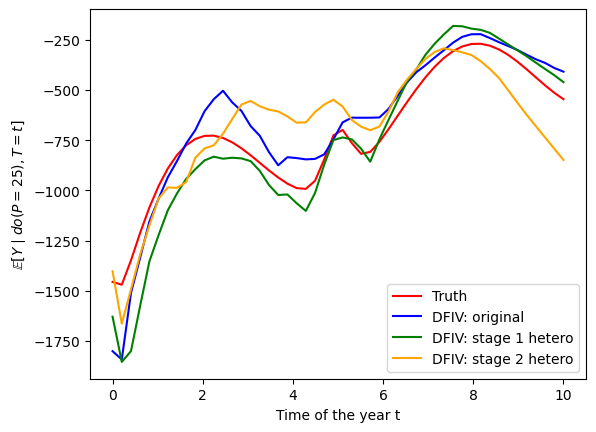

In [29]:
fig, ax = plt.subplots()
time = time.squeeze()
l1 = ax.plot(time, true_demand, color='red', label='Truth')
l2 = ax.plot(time, original_demand, color='blue', label='DFIV: original')
l3 = ax.plot(time, stage_1_pred_demand, color='green', label='DFIV: stage 1 hetero')
l4 = ax.plot(time, stage_2_pred_demand, color='orange', label='DFIV: stage 2 hetero')
ax.legend()

ax.set_xlabel('Time of the year t')
ax.set_ylabel('$\mathbb{E}[Y\mid do(P=25), T=t]$')
plt.savefig(f'images/CATE_HST.pdf')
plt.show()

# ATE

In [30]:
# vary p: fix t = E[t] = 5, S = E[S] = 4
emotion_range = np.array([1, 2, 3, 4, 5, 6, 7])
price = np.ones(num_point) * np.linspace(10, 25, num_point)
time = np.linspace(0.0, 10, num_point)
emotion = (np.ones(num_point) * np.mean(emotion_range))
covariate = np.c_[time, emotion]

In [31]:
G = np.mean(psi(time)) * np.mean(emotion_range)
coef = G - 2
offset = 100 + 10 * G

true_demand = coef * price + offset

In [32]:
# # vary p: fix t = E[t] = 5, S = E[S] = 4
# emotion_range = np.array([1, 2, 3, 4, 5, 6, 7])
# price_val = np.linspace(10, 25, num_point)
# price = np.ones(num_point) * price_val
# time = np.array([5] * num_point)
# emotion = (np.ones(num_point) * np.mean(emotion_range))
# covariate = np.c_[time, emotion]

In [33]:
original_demand = []
for p in price:
    p = (np.ones(num_point) * p)[:, np.newaxis]
    pred = np.mean((predict_dfiv_model(dfiv_original_model, p, covariate)))
    original_demand.append(pred)

stage_1_pred_demand = []
for p in price:
    p = (np.ones(num_point) * p)[:, np.newaxis]
    pred = np.mean((predict_dfiv_model(dfiv_hetero_stage_1_model, p, covariate)))
    stage_1_pred_demand.append(pred)
    
stage_2_pred_demand = []
for p in price:
    p = (np.ones(num_point) * p)[:, np.newaxis]
    pred = np.mean((predict_dfiv_model(dfiv_hetero_stage_2_model, p, covariate)))
    stage_2_pred_demand.append(pred)

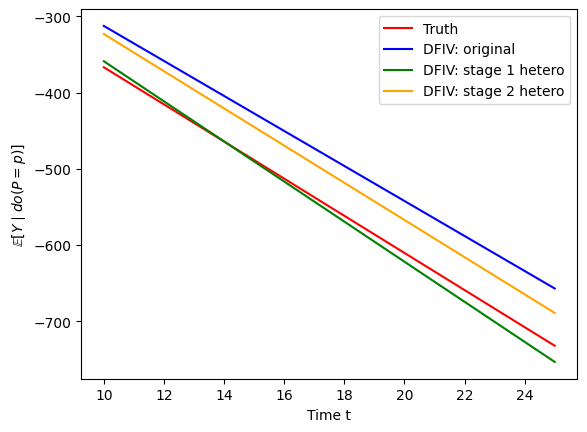

In [34]:
fig, ax = plt.subplots()
price = price.squeeze()
l1 = ax.plot(price, true_demand, color='red', label='Truth')
l2 = ax.plot(price, original_demand, color='blue', label='DFIV: original')
l3 = ax.plot(price, stage_1_pred_demand, color='green', label='DFIV: stage 1 hetero')
l4 = ax.plot(price, stage_2_pred_demand, color='orange', label='DFIV: stage 2 hetero')
ax.legend()

ax.set_xlabel('Time t')
ax.set_ylabel('$\mathbb{E}[Y\mid do(P=p)]$')
plt.savefig(f'images/ATE_HST.pdf')
plt.show()

# Average DFIV

In [35]:
df_merged = pd.concat([df_original.assign(type='original'),
                       df_stage_1.assign(type='stage_1'),
                       df_stage_2.assign(type='stage_2')])

In [36]:
df_merged.groupby(['type', 'sigma']).mean().reset_index()

,type,sigma,rho,test loss
0,original,0.0,0.5,26345.221976
1,stage_1,0.0,0.5,58818.069125
2,stage_1,0.2,0.5,51568.617723
3,stage_1,1.0,0.5,59838.294971
4,stage_1,1.8,0.5,92136.743741
5,stage_2,0.0,0.5,39443.654726
6,stage_2,0.2,0.5,114674.351169
7,stage_2,1.0,0.5,58499.167258
8,stage_2,1.8,0.5,47107.342432
